## Importar as libs

In [1]:
import warnings

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

# Configurações para melhor visualização
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

In [2]:
print("Versão do TensorFlow:", tf.__version__)

# Tenta listar os dispositivos GPU físicos disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Mostra a lista de GPUs encontradas
    print("GPUs disponíveis:", gpus)

    # Configura o TensorFlow para usar a primeira GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print("GPU configurada com sucesso!")
  except RuntimeError as e:
    # Se algo der errado na configuração
    print(e)
else:
  print("Nenhuma GPU encontrada. O TensorFlow está rodando em CPU.")

Versão do TensorFlow: 2.18.1
Nenhuma GPU encontrada. O TensorFlow está rodando em CPU.


## Obtenção de dados

In [3]:
print("O diretório atual onde o notebook está sendo executado é:")
print(os.getcwd())

print("\nConteúdo do diretório atual:")
for item in os.listdir('.'):
    print(item)

O diretório atual onde o notebook está sendo executado é:
d:\Repository\faculdade\tp_pdi\notebooks

Conteúdo do diretório atual:
download_mpiigaze.ipynb
finetune.ipynb
pre_processamento.ipynb
processamento.ipynb
tp_pdi.ipynb


In [4]:
def carregar_dados():
    """
    Carrega os dados processados do arquivo CSV
    """
    print("Carregando dados...")
    
    # Carrega o arquivo CSV
    df = pd.read_csv('../output/gaze_labels.csv')

    # Remove espaços em branco dos nomes das colunas
    df.columns = df.columns.str.strip()
    
    print(f"Dataset carregado com {len(df)} registros")
    print(f"Colunas disponíveis: {list(df.columns)}")
    
    return df

In [5]:



def explorar_dados(df):
    """
    Explora e visualiza os dados carregados
    """
    print("\n=== EXPLORAÇÃO DOS DADOS ===")
    
    # Informações básicas
    print(f"Shape do dataset: {df.shape}")
    print(f"\nTipos de dados:")
    print(df.dtypes)
    
    # Estatísticas descritivas
    print(f"\nEstatísticas descritivas:")
    print(df.describe())
    
    # Verificar valores nulos
    print(f"\nValores nulos por coluna:")
    print(df.isnull().sum())
    
    # Distribuição da variável target
    print(f"\nDistribuição da variável 'attention':")
    print(df['attention'].value_counts())
    print(f"Proporção:")
    print(df['attention'].value_counts(normalize=True))
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribuição da atenção
    axes[0, 0].pie(df['attention'].value_counts(), labels=['Sem Atenção', 'Com Atenção'], 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribuição da Variável Target (Attention)')
    
    # Distribuição dos vetores de olhar
    axes[0, 1].hist(df['look_vec_x'], bins=50, alpha=0.7, label='X')
    axes[0, 1].hist(df['look_vec_y'], bins=50, alpha=0.7, label='Y')
    axes[0, 1].hist(df['look_vec_z'], bins=50, alpha=0.7, label='Z')
    axes[0, 1].set_title('Distribuição dos Vetores de Olhar')
    axes[0, 1].legend()
    
    # Tamanho da pupila
    axes[1, 0].hist(df['pupil_size'], bins=50, alpha=0.7)
    axes[1, 0].set_title('Distribuição do Tamanho da Pupila')
    
    # Correlação entre variáveis
    correlation_matrix = df[['look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size', 'attention']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1, 1])
    axes[1, 1].set_title('Matriz de Correlação')
    
    plt.tight_layout()
    plt.show()
    
    return df



In [6]:

def preprocessar_dados(df, sequence_length=10):
    """
    Pré-processa os dados para treinamento da LSTM
    
    Args:
        df: DataFrame com os dados
        sequence_length: Comprimento da sequência para LSTM
    """
    print(f"\n=== PRÉ-PROCESSAMENTO DOS DADOS ===")
    print(f"Comprimento da sequência: {sequence_length}")
    
    # Seleciona as features relevantes
    features = ['look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size']
    target = 'attention'
    
    # Remove linhas com valores nulos
    df_clean = df.dropna()
    print(f"Dados após remoção de nulos: {len(df_clean)} registros")
    
    # Normalização das features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_clean[features])
    
    # Criação de sequências para LSTM
    X_sequences = []
    y_sequences = []
    
    for i in range(len(features_scaled) - sequence_length + 1):
        X_sequences.append(features_scaled[i:i + sequence_length])
        y_sequences.append(df_clean[target].iloc[i + sequence_length - 1])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    print(f"Shape das sequências X: {X_sequences.shape}")
    print(f"Shape das sequências y: {y_sequences.shape}")
    
    # Codificação one-hot para a variável target
    y_encoded = to_categorical(y_sequences, num_classes=2)
    
    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_encoded, test_size=0.2, random_state=42, stratify=y_sequences
    )
    
    # Divisão do treino em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
    )
    
    print(f"Shape dos dados de treino: {X_train.shape}")
    print(f"Shape dos dados de validação: {X_val.shape}")
    print(f"Shape dos dados de teste: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler



In [7]:
def criar_modelo_lstm(input_shape, num_classes=2):
    """
    Cria o modelo LSTM para classificação
    
    Args:
        input_shape: Shape dos dados de entrada (sequence_length, num_features)
        num_classes: Número de classes (2 para binário)
    """
    print(f"\n=== CRIAÇÃO DO MODELO LSTM ===")
    print(f"Input shape: {input_shape}")
    print(f"Número de classes: {num_classes}")
    
    model = Sequential([
        # Primeira camada LSTM
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Segunda camada LSTM
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        # Terceira camada LSTM
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        # Camadas densas
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Camada de saída
        Dense(num_classes, activation='softmax')
    ])
    
    # Compilação do modelo
    model.compile(
        optimizer= Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Resumo do modelo
    model.summary()
    
    return model

In [8]:
def treinar_modelo(model, X_train, y_train, X_val, y_val):
    """
    Treina o modelo LSTM
    
    Args:
        model: Modelo LSTM criado
        X_train, y_train: Dados de treino
        X_val, y_val: Dados de validação
    """
    print(f"\n=== TREINAMENTO DO MODELO ===")
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'melhor_modelo_lstm.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Treinamento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=128,
    )
    
    return history


In [9]:

def avaliar_modelo(model, X_test, y_test, history):
    """
    Avalia o modelo treinado
    
    Args:
        model: Modelo treinado
        X_test, y_test: Dados de teste
        history: Histórico do treinamento
    """
    print(f"\n=== AVALIAÇÃO DO MODELO ===")
    
    # Predições
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Métricas
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
    
    # Relatório de classificação
    print(f"\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=['Sem Atenção', 'Com Atenção']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sem Atenção', 'Com Atenção'],
                yticklabels=['Sem Atenção', 'Com Atenção'])
    plt.title('Matriz de Confusão')
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predito')
    plt.show()
    
    # Gráficos de treinamento
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Acurácia
    axes[0].plot(history.history['accuracy'], label='Treino')
    axes[0].plot(history.history['val_accuracy'], label='Validação')
    axes[0].set_title('Acurácia durante o Treinamento')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Treino')
    axes[1].plot(history.history['val_loss'], label='Validação')
    axes[1].set_title('Loss durante o Treinamento')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, y_true


In [10]:
"""
Função principal que executa todo o pipeline
"""
print("=== TREINAMENTO DE LSTM PARA ANÁLISE DE OLHAR ===")
print("Dataset: UnityEyes - Dados processados\n")

# Carregamento dos dados
df = carregar_dados()

=== TREINAMENTO DE LSTM PARA ANÁLISE DE OLHAR ===
Dataset: UnityEyes - Dados processados

Carregando dados...
Dataset carregado com 272879 registros
Colunas disponíveis: ['filename', 'look_vec_x', 'look_vec_y', 'look_vec_z', 'pupil_size', 'attention']



=== EXPLORAÇÃO DOS DADOS ===
Shape do dataset: (272879, 6)

Tipos de dados:
filename       object
look_vec_x    float64
look_vec_y    float64
look_vec_z    float64
pupil_size    float64
attention       int64
dtype: object

Estatísticas descritivas:
          look_vec_x     look_vec_y     look_vec_z     pupil_size  \
count  272879.000000  272879.000000  272879.000000  272879.000000   
mean        0.002363       0.000528      -0.822767       0.000083   
std         0.436071       0.334328       0.145319       0.199846   
min        -0.937400      -0.761400      -1.000000      -0.958819   
25%        -0.339200      -0.260700      -0.939400      -0.134801   
50%         0.002700       0.001200      -0.859400       0.000235   
75%         0.344600       0.262300      -0.740600       0.134846   
max         0.936000       0.762400      -0.158000       0.896891   

           attention  
count  272879.000000  
mean        0.087841  
std         0.283064  
min         0.000000  
25%         0

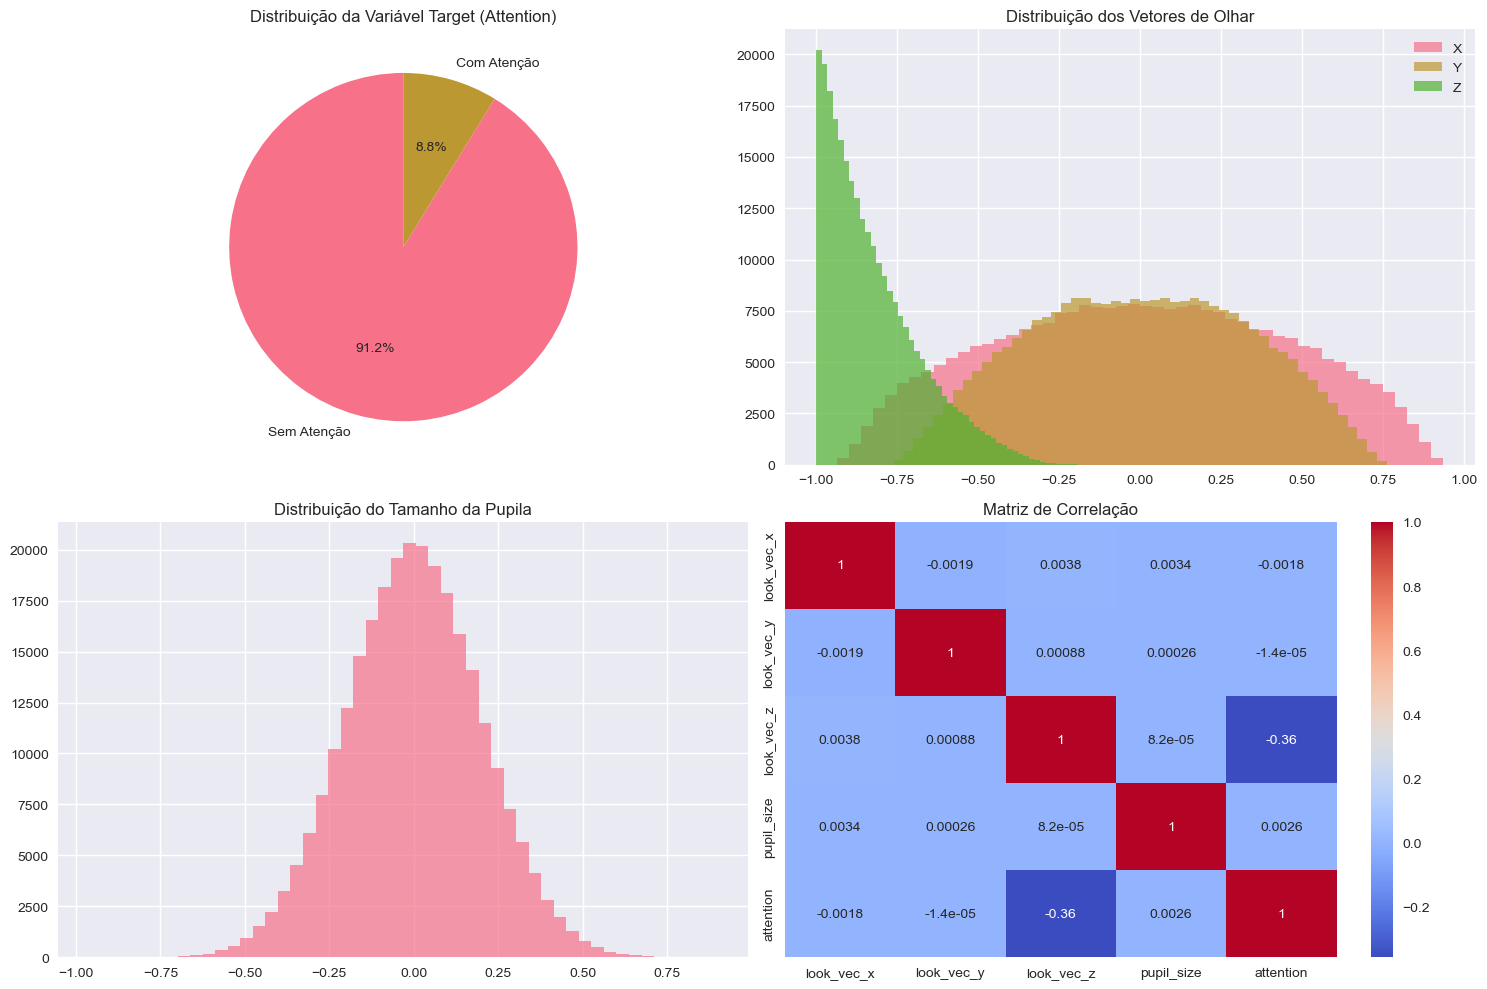

In [11]:
# Exploração dos dados
df = explorar_dados(df)

In [12]:
# Pré-processamento
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocessar_dados(df, sequence_length=10)


=== PRÉ-PROCESSAMENTO DOS DADOS ===
Comprimento da sequência: 10
Dados após remoção de nulos: 272879 registros
Shape das sequências X: (272870, 10, 4)
Shape das sequências y: (272870,)
Shape dos dados de treino: (174636, 10, 4)
Shape dos dados de validação: (43660, 10, 4)
Shape dos dados de teste: (54574, 10, 4)


In [13]:
# Criação do modelo
model = criar_modelo_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))


=== CRIAÇÃO DO MODELO LSTM ===
Input shape: (10, 4)
Número de classes: 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,458 (529.13 KB)

 Trainable params: 134,818 (526.63 KB)

 Non-trainable params: 640 (2.50 KB)

In [14]:
# Treinamento
history = treinar_modelo(model, X_train, y_train, X_val, y_val)


=== TREINAMENTO DO MODELO ===


Epoch 1/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.6533 - loss: 0.6853 - val_accuracy: 0.9113 - val_loss: 0.4577
Epoch 2/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8641 - loss: 0.4368 - val_accuracy: 0.9122 - val_loss: 0.3145
Epoch 3/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9048 - loss: 0.3383 - val_accuracy: 0.9122 - val_loss: 0.2845
Epoch 4/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9096 - loss: 0.3052 - val_accuracy: 0.9122 - val_loss: 0.2346
Epoch 5/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.9180 - loss: 0.2146 - val_accuracy: 0.9590 - val_loss: 0.0936
Epoch 6/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.9498 - loss: 0.1235 - val_accuracy: 0.9842 - val_loss: 0.0464
Epoch 7/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9684 - loss: 0.0811 - val_accuracy: 0.9900 - val_loss: 0.0305
Epoch 8/100
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 


=== AVALIAÇÃO DO MODELO ===
1706/1706 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Acurácia no conjunto de teste: 0.9975

Relatório de Classificação:
              precision    recall  f1-score   support

 Sem Atenção       1.00      1.00      1.00     49780
 Com Atenção       0.99      0.98      0.99      4794

    accuracy                           1.00     54574
   macro avg       0.99      0.99      0.99     54574
weighted avg       1.00      1.00      1.00     54574



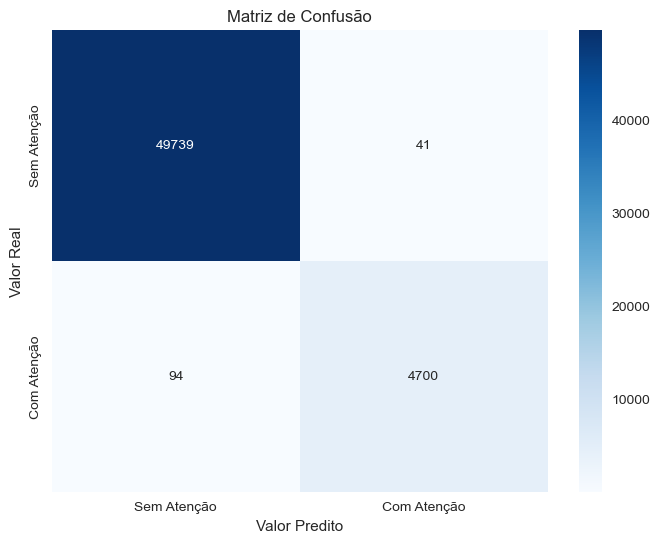

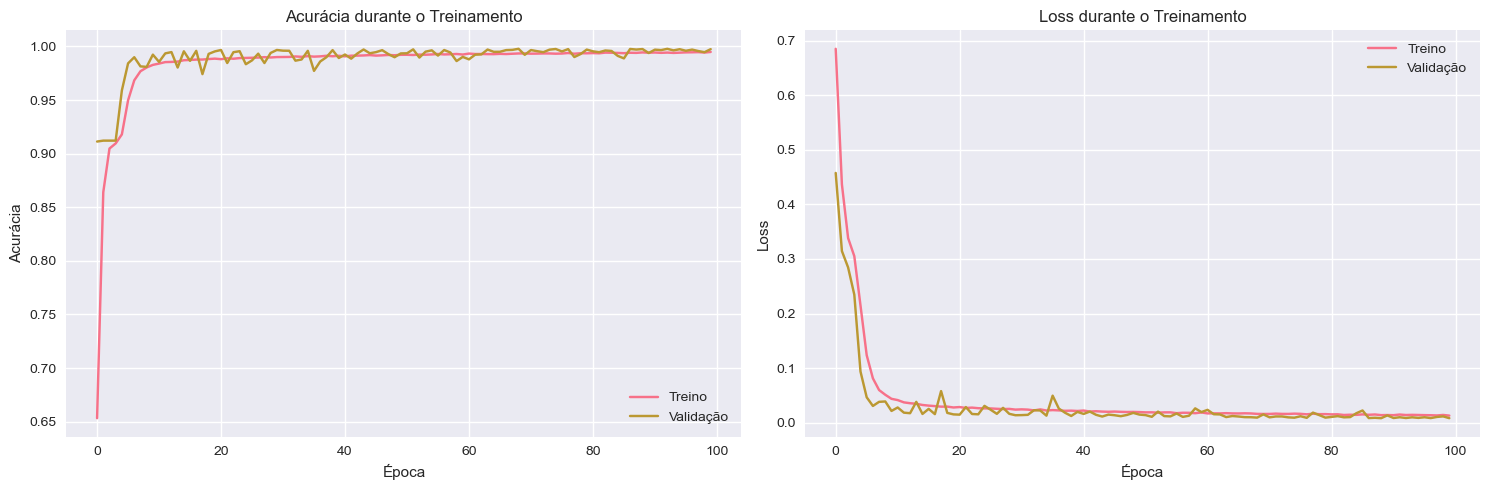

In [15]:
# Avaliação
accuracy, y_pred, y_true = avaliar_modelo(model, X_test, y_test, history)

In [17]:

print(f"\n=== RESUMO FINAL ===")
print(f"Acurácia final no conjunto de teste: {accuracy:.4f}")
print(f"Modelo salvo como: 'melhor_modelo_lstm.h5'")


=== RESUMO FINAL ===
Acurácia final no conjunto de teste: 0.9975
Modelo salvo como: 'melhor_modelo_lstm.h5'


In [1]:
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("dhruv413/mpiigaze")

print("Path to dataset files:", path)

100%|██████████| 2.08G/2.08G [01:13<00:00, 30.2MB/s]

Extracting model files...


Path to dataset files: C:\Users\pedro\.cache\kagglehub\datasets\dhruv413\mpiigaze\versions\1


In [2]:
import os
import numpy as np
import cv2
import scipy.io as sio
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd

c:\Users\pedro\anaconda3\envs\new_pdi\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
# --- Configurações de Caminho ---
CAMINHO_BASE = '..'
MODEL_PATH = os.path.join(CAMINHO_BASE, 'models')
OUTPUT_PATH = os.path.join(CAMINHO_BASE, 'output')
MODELO_SALVO = os.path.join(MODEL_PATH, '.gaze_model.keras')
LABELS_FILE_SYNTHETIC = os.path.join(OUTPUT_PATH, 'gaze_labels.csv')

# --- Caminho Corrigido para os Dados Reais do MPIIGaze ---
MPIIGAZE_DIR = os.path.join(CAMINHO_BASE, 'mpiigaze_real', 'MPIIGaze')
REAL_DATA_ROOT = os.path.join(MPIIGAZE_DIR, 'Data', 'Original')

In [ ]:


# Tamanho da imagem redimensionada
IMG_SIZE = (64, 64)

# --- 1. Preparação dos Dados Reais (MPIIGaze) ---
print("Verificando se o dataset MPIIGaze já existe...")
if not os.path.exists(MPIIGAZE_DIR):
    print("Dataset MPIIGaze não encontrado. Baixe e descompacte o arquivo 'mpiigaze.zip' na raiz do seu projeto.")
    exit()

try:
    import scipy.io as sio
except ImportError:
    print("A biblioteca scipy não está instalada. Instalando...")
    !pip install scipy
    import scipy.io as sio

print("Processando dados do MPIIGaze...")
X_real = []
y_real = []

if os.path.exists(REAL_DATA_ROOT):
    USER_NAMES = sorted([d for d in os.listdir(REAL_DATA_ROOT) if d.startswith('p')])
    for user in USER_NAMES:
        user_dir = os.path.join(REAL_DATA_ROOT, user)
        day_folders = sorted([d for d in os.listdir(user_dir) if os.path.isdir(os.path.join(user_dir, d))])
        
        for day in day_folders:
            day_dir = os.path.join(user_dir, day)
            
            annotation_file = os.path.join(day_dir, 'annotation.mat')
            
            # --- CORREÇÃO AQUI: Assumimos que as imagens estão em uma pasta 'Image' dentro do dia ---
            images_folder = os.path.join(day_dir, 'image')

            if os.path.exists(annotation_file) and os.path.exists(images_folder):
                mat_data = sio.loadmat(annotation_file)
                gaze_labels = mat_data['gaze']
                gaze_threshold = 0.1
                labels = np.linalg.norm(gaze_labels, axis=1) < gaze_threshold
                
                image_filenames = sorted([f for f in os.listdir(images_folder) if f.endswith('.jpg')])

                for i, image_filename in enumerate(image_filenames):
                    image_path = os.path.join(images_folder, image_filename)
                    img = cv2.imread(image_path)
                    if img is not None:
                        img_resized = cv2.resize(img, IMG_SIZE)
                        img_normalized = img_resized.astype('float32') / 255.0
                        X_real.append(img_normalized)
                        y_real.append(labels[i])
                            
X_real = np.array(X_real)
y_real = np.array(y_real)
print(f"Dados reais processados. Total de imagens: {len(X_real)}")

if len(X_real) == 0:
    print("Nenhuma imagem foi processada. Verifique se a estrutura de diretórios do seu dataset MPIIGaze é a esperada (Data/Normalized/pXX/dayXX/image/images.jpg).")
    exit()

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)


Verificando se o dataset MPIIGaze já existe...
Processando dados do MPIIGaze...
Dados reais processados. Total de imagens: 0
Nenhuma imagem foi processada. Verifique se a estrutura de diretórios do seu dataset MPIIGaze é a esperada (Data/Normalized/pXX/dayXX/image/images.jpg).


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

: 

In [ ]:



# --- 2. Carregar seu Modelo Pré-treinado ---
print("\nCarregando modelo pré-treinado...")
if os.path.exists(MODELO_SALVO):
    pre_trained_model = tf.keras.models.load_model(MODELO_SALVO)
    print("Modelo pré-treinado carregado com sucesso!")
else:
    print(f"Erro: O modelo '{MODELO_SALVO}' não foi encontrado.")
    exit()

# --- 3. Configurar para Fine-Tuning com taxa de aprendizado baixa ---
print("\nConfigurando o modelo para fine-tuning...")
fine_tune_optimizer = Adam(learning_rate=0.00001)

pre_trained_model.compile(optimizer=fine_tune_optimizer,
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

# --- 4. Treinar com os Dados Reais ---
print("\nIniciando o fine-tuning com dados reais...")
callback_fine_tune = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_fine_tune = pre_trained_model.fit(
    X_real_train, y_real_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_real_test, y_real_test),
    callbacks=[callback_fine_tune]
)

# --- 5. Avaliar e Salvar o Modelo ---
loss_real, accuracy_real = pre_trained_model.evaluate(X_real_test, y_real_test)
print(f"\nAcurácia final do modelo após fine-tuning: {accuracy_real:.4f}")
pre_trained_model.save('gaze_attention_model_fine_tuned.keras')
print("Modelo fine-tuned salvo.")

Verificando se o dataset MPIIGaze já existe...
Processando dados do MPIIGaze...
Dados reais processados. Total de imagens: 0
Nenhuma imagem foi processada. Verifique se a estrutura de diretórios do seu dataset MPIIGaze é a esperada (Data/Normalized/pXX/dayXX/image/images.jpg).


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

: 